In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Weed_Features.csv to Weed_Features.csv


In [4]:
data = pd.read_csv('Weed_Features.csv')

In [5]:
#features = data[['rgb_mean', 'histogram', 'average_intensity', 'laplace_mean', 'edge_mean', 'gabor_response_array', 'std']]
features = data[['rgb_mean', 'average_intensity', 'laplace_mean', 'edge_mean', 'std']]
#features['histogram'] = features['histogram'].apply(lambda x: pd.DataFrame([float(j) for j in [i.strip() for i in x[1:-1].split(' ')] if j]))
gabor = pd.DataFrame(data['gabor_response_array'].apply(lambda x: [float(j) for j in [i.strip() for i in x[1:-1].split(' ')] if j]))
gabor_flattened = pd.DataFrame(gabor['gabor_response_array'].to_list())
features_with_garbor = pd.concat([features, gabor_flattened], axis=1)
labels = data['label']

#Validation function

In [159]:
def validation_param_search(im_pipeline, X_train, X_test, y_train, y_test, param_dict):
  X_tval, X_val, y_tval, y_val = train_test_split(X_train, y_train, test_size=0.2/0.9)
  score_array = []
  for n in list(param_dict.values())[0]:
    im_pipeline.set_params(**{list(param_dict.keys())[0]:n})
    im_pipeline.fit(X_tval, y_tval)
    y_val_pred = im_pipeline.predict(X_val)
    score_array.append(f1_score(y_val, y_val_pred, average='micro'))
  return score_array

#KNN on engineered features with LDA with V and undersampling

In [160]:
from sklearn.model_selection import train_test_split

X_train_KNN, X_test_KNN, y_train_KNN, y_test_KNN = train_test_split(features_with_garbor, labels.to_numpy(), test_size=0.1)

In [161]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import neighbors
from sklearn.metrics import f1_score

In [162]:
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
knn = neighbors.KNeighborsClassifier(n_neighbors = 1, metric='euclidean')
im_pipeline = make_pipeline(undersampler, lda, knn)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'lineardiscriminantanalysis', 'kneighborsclassifier', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'lineardiscriminantanalysis__covariance_estimator', 'lineardiscriminantanalysis__n_components', 'lineardiscriminantanalysis__priors', 'lineardiscriminantanalysis__shrinkage', 'lineardiscriminantanalysis__solver', 'lineardiscriminantanalysis__store_covariance', 'lineardiscriminantanalysis__tol', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Text(0, 0.5, 'mean test scores')

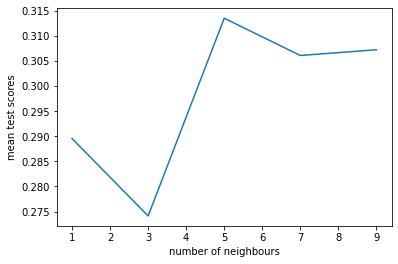

In [163]:
param_name = 'kneighborsclassifier__n_neighbors'
param_values = [x for x in range(1, 10) if x%2 != 0]

score_array = validation_param_search(im_pipeline, X_train_KNN, X_test_KNN, y_train_KNN, y_test_KNN, {param_name:param_values})

plt.plot(param_values, score_array)
plt.xlabel('number of neighbours')
plt.ylabel('mean test scores')

Actual Model:

In [196]:
from sklearn import neighbors
from sklearn.metrics import classification_report

In [197]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
X_train_U, y_train_U = undersampler.fit_resample(X_train_KNN, y_train_KNN)
X_train_U_LDA = lda.fit_transform(X_train_U, y_train_U)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [198]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 7, metric='euclidean')
knn_model = knn.fit(X_train_U_LDA, y_train_U)
X_test_LDA = lda.transform(X_test_KNN)
y_pred_knn = knn.predict(X_test_LDA)
print(classification_report(y_test_KNN, y_pred_knn))

              precision    recall  f1-score   support

           0       0.24      0.45      0.31       108
           1       0.19      0.39      0.26        87
           2       0.26      0.58      0.36       104
           3       0.21      0.39      0.27       103
           4       0.30      0.54      0.39       121
           5       0.24      0.45      0.31       109
           6       0.23      0.44      0.30       111
           7       0.25      0.31      0.27       116
           8       0.86      0.17      0.28       892

    accuracy                           0.30      1751
   macro avg       0.31      0.41      0.31      1751
weighted avg       0.56      0.30      0.30      1751



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Text(0.5, 33.0, 'Predicted')

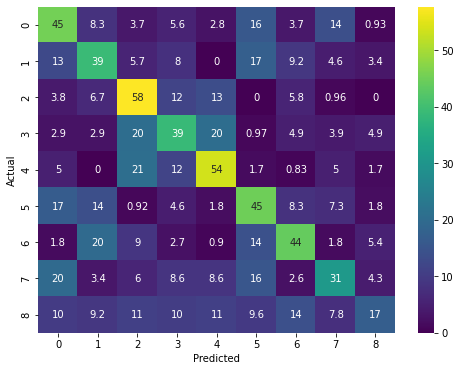

In [199]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test_KNN)):
  predicted = y_pred_knn[i]
  actual = y_test_KNN[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test_KNN, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#SVM on engineered features with LDA with V and undersampling

In [168]:
from sklearn.model_selection import train_test_split

X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(features_with_garbor, labels.to_numpy(), test_size=0.1)

In [169]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import svm
from sklearn.metrics import f1_score

In [170]:
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
svmclf = svm.SVC(kernel='rbf')
im_pipeline = make_pipeline(undersampler, lda, svmclf)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'lineardiscriminantanalysis', 'svc', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'lineardiscriminantanalysis__covariance_estimator', 'lineardiscriminantanalysis__n_components', 'lineardiscriminantanalysis__priors', 'lineardiscriminantanalysis__shrinkage', 'lineardiscriminantanalysis__solver', 'lineardiscriminantanalysis__store_covariance', 'lineardiscriminantanalysis__tol', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Text(0, 0.5, 'mean test scores')

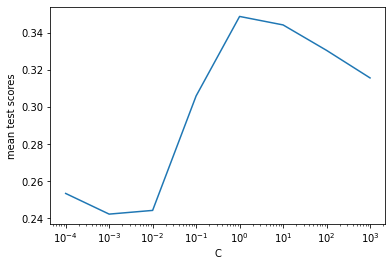

In [171]:
param_name = 'svc__C'
param_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

score_array = validation_param_search(im_pipeline, X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM, {param_name:param_values})

plt.plot(param_values, score_array)
plt.xscale("log")
plt.xlabel('C')
plt.ylabel('mean test scores')

Actual Model:

In [200]:
from sklearn import svm
from sklearn.metrics import classification_report

In [201]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
X_train_U, y_train_U = undersampler.fit_resample(X_train_SVM, y_train_SVM)
X_train_U_LDA = lda.fit_transform(X_train_U, y_train_U)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [202]:
svmclf = svm.SVC(kernel='rbf', C=1)
svm_model = svmclf.fit(X_train_U_LDA, y_train_U)
X_test_LDA = lda.transform(X_test_SVM)
y_pred_svm = svmclf.predict(X_test_LDA)
print(classification_report(y_test_SVM, y_pred_svm))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


              precision    recall  f1-score   support

           0       0.34      0.40      0.37       116
           1       0.34      0.43      0.38       100
           2       0.33      0.57      0.41       117
           3       0.26      0.52      0.35       102
           4       0.32      0.66      0.43       137
           5       0.27      0.55      0.36       110
           6       0.24      0.48      0.32       105
           7       0.29      0.40      0.34       111
           8       0.84      0.20      0.33       853

    accuracy                           0.36      1751
   macro avg       0.36      0.47      0.36      1751
weighted avg       0.56      0.36      0.35      1751



Text(0.5, 33.0, 'Predicted')

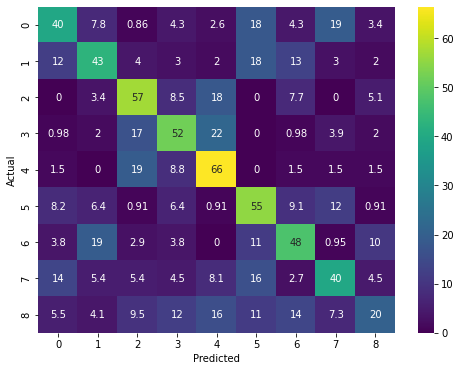

In [203]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test_SVM)):
  predicted = y_pred_svm[i]
  actual = y_test_SVM[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test_SVM, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#Random Forest on engineered features with LDA with V and undersampling

In [176]:
from sklearn.model_selection import train_test_split

X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(features_with_garbor, labels.to_numpy(), test_size=0.1)

In [177]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [178]:
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
rf=RandomForestClassifier()
im_pipeline = make_pipeline(undersampler, lda, rf)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'lineardiscriminantanalysis', 'randomforestclassifier', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'lineardiscriminantanalysis__covariance_estimator', 'lineardiscriminantanalysis__n_components', 'lineardiscriminantanalysis__priors', 'lineardiscriminantanalysis__shrinkage', 'lineardiscriminantanalysis__solver', 'lineardiscriminantanalysis__store_covariance', 'lineardiscriminantanalysis__tol', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__m

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Text(0, 0.5, 'mean test scores')

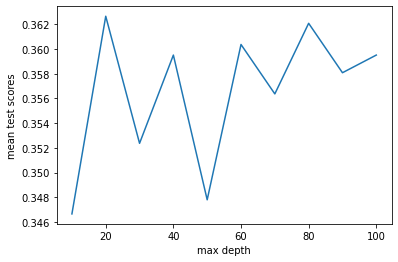

In [179]:
param_name = 'randomforestclassifier__max_depth'
param_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

score_array = validation_param_search(im_pipeline, X_train_RF, X_test_RF, y_train_RF, y_test_RF, {param_name:param_values})

plt.plot(param_values, score_array)
plt.xlabel('max depth')
plt.ylabel('mean test scores')

Actual Model:

In [204]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [205]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
X_train_U, y_train_U = undersampler.fit_resample(X_train_RF, y_train_RF)
X_train_U_LDA = lda.fit_transform(X_train_U, y_train_U)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [206]:
rf = RandomForestClassifier(max_depth=20)
rf_model = rf.fit(X_train_U_LDA, y_train_U)
X_test_LDA = lda.transform(X_test_RF)
y_pred_rf = rf.predict(X_test_LDA)
print(classification_report(y_test_RF, y_pred_rf))

              precision    recall  f1-score   support

           0       0.26      0.43      0.32       108
           1       0.30      0.40      0.34       104
           2       0.32      0.52      0.39       103
           3       0.29      0.51      0.37       107
           4       0.31      0.59      0.41       113
           5       0.27      0.47      0.34        99
           6       0.23      0.52      0.32       101
           7       0.26      0.39      0.31        98
           8       0.81      0.27      0.41       918

    accuracy                           0.37      1751
   macro avg       0.34      0.46      0.36      1751
weighted avg       0.56      0.37      0.38      1751



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Text(0.5, 33.0, 'Predicted')

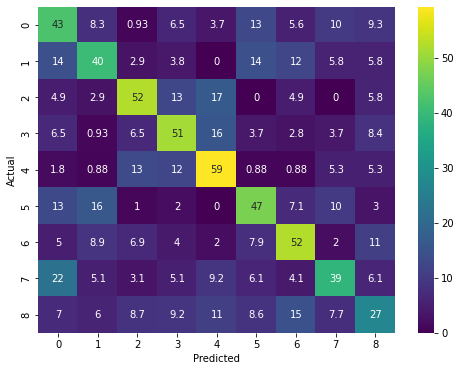

In [207]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test_RF)):
  predicted = y_pred_rf[i]
  actual = y_test_RF[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test_RF, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#Logistic Regression on engineered features with LDA with V and undersampling

In [184]:
from sklearn.model_selection import train_test_split

X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(features_with_garbor, labels.to_numpy(), test_size=0.1)

In [185]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [186]:
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
lr=LogisticRegression()
im_pipeline = make_pipeline(undersampler, lda, lr)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'lineardiscriminantanalysis', 'logisticregression', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'lineardiscriminantanalysis__covariance_estimator', 'lineardiscriminantanalysis__n_components', 'lineardiscriminantanalysis__priors', 'lineardiscriminantanalysis__shrinkage', 'lineardiscriminantanalysis__solver', 'lineardiscriminantanalysis__store_covariance', 'lineardiscriminantanalysis__tol', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Text(0, 0.5, 'mean test scores')

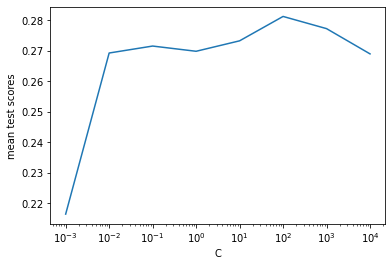

In [187]:
param_name = 'logisticregression__C'
param_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

score_array = validation_param_search(im_pipeline, X_train, X_test, y_train, y_test, {param_name:param_values})

plt.plot(param_values, score_array)
plt.xscale("log")
plt.xlabel('C')
plt.ylabel('mean test scores')

Actual Model:

In [208]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [209]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
X_train_U, y_train_U = undersampler.fit_resample(X_train_LR, y_train_LR)
X_train_U_LDA = lda.fit_transform(X_train_U, y_train_U)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [210]:
lr = LogisticRegression(C=100)
lr_model = lr.fit(X_train_U_LDA, y_train_U)
X_test_LDA = lda.transform(X_test_LR)
y_pred_lr = lr.predict(X_test_LDA)
print(classification_report(y_test_LR, y_pred_lr))

              precision    recall  f1-score   support

           0       0.31      0.40      0.35       111
           1       0.21      0.29      0.25       103
           2       0.18      0.55      0.27       112
           3       0.12      0.17      0.14        96
           4       0.20      0.43      0.28       109
           5       0.26      0.42      0.32       113
           6       0.22      0.36      0.28       109
           7       0.13      0.16      0.14       104
           8       0.72      0.21      0.33       894

    accuracy                           0.28      1751
   macro avg       0.26      0.33      0.26      1751
weighted avg       0.47      0.28      0.29      1751



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Text(0.5, 33.0, 'Predicted')

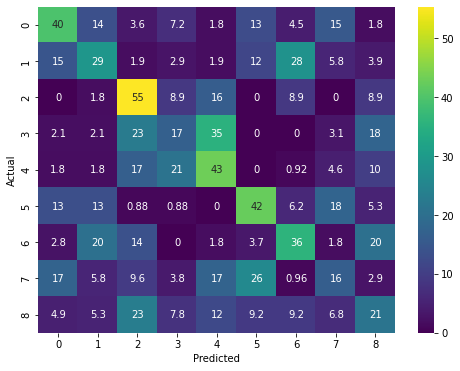

In [211]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test_LR)):
  predicted = y_pred_lr[i]
  actual = y_test_LR[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test_LR, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#Dummy classifier for reference

In [192]:
from sklearn.model_selection import train_test_split

X_train_D, X_test_D, y_train_D, y_test_D = train_test_split(features_with_garbor, labels.to_numpy(), test_size=0.1)

In [193]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

In [194]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
undersampler = RandomUnderSampler()
lda = LinearDiscriminantAnalysis()
X_train_U, y_train_U = undersampler.fit_resample(X_train_D, y_train_D)
X_train_U_LDA = lda.fit_transform(X_train_U, y_train_U)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [195]:
dummy_clf = DummyClassifier(strategy="uniform")
dummy_model = dummy_clf.fit(X_train_U_LDA, y_train_U)
X_test_LDA = lda.transform(X_test_D)
y_pred_dummy = dummy_clf.predict(X_test_LDA)
print(classification_report(y_test_D, y_pred_dummy))

              precision    recall  f1-score   support

           0       0.07      0.12      0.09       108
           1       0.07      0.11      0.09       115
           2       0.06      0.10      0.07       105
           3       0.06      0.12      0.08       103
           4       0.06      0.13      0.08       102
           5       0.06      0.11      0.08       108
           6       0.02      0.04      0.03        92
           7       0.07      0.14      0.09        99
           8       0.49      0.10      0.17       919

    accuracy                           0.11      1751
   macro avg       0.11      0.11      0.09      1751
weighted avg       0.29      0.11      0.13      1751



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
